In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# Load datasets
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, parse_dates=['date'])
    df.set_index('date', inplace=True)
    df.replace(' ', np.nan, inplace=True)  # Replace empty strings with NaN
    df = df.dropna().astype(float)  # Drop NaN values and ensure numeric type
    return df

In [3]:
# Upload files manually in Colab or use Google Drive paths
rjy_data = load_and_preprocess('rjy.csv')
vizag_data = load_and_preprocess('vizag.csv')
amar_data = load_and_preprocess('amar.csv')
hyd_data = load_and_preprocess('hyd.csv')

In [4]:
# Normalize data
scaler = MinMaxScaler()
all_data = np.vstack([rjy_data, vizag_data, amar_data, hyd_data])  # Stack all data for consistent scaling
scaler.fit(all_data)

rjy_scaled = scaler.transform(rjy_data)
vizag_scaled = scaler.transform(vizag_data)
amar_scaled = scaler.transform(amar_data)
hyd_scaled = scaler.transform(hyd_data)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [5]:
# Function to create sequences
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])  # Predict all 6 parameters
    return np.array(X), np.array(y)

seq_length = 10
X_rjy, y_rjy = create_sequences(rjy_scaled, seq_length)
X_vizag, y_vizag = create_sequences(vizag_scaled, seq_length)
X_amar, y_amar = create_sequences(amar_scaled, seq_length)
X_hyd, y_hyd = create_sequences(hyd_scaled, seq_length)

In [6]:
# Combine all datasets for training
X_all = np.concatenate([X_rjy, X_vizag, X_amar, X_hyd])
y_all = np.concatenate([y_rjy, y_vizag, y_amar, y_hyd])

In [7]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(y_train.shape[1])  # Output layer predicts all 6 parameters
])

model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0100 - val_loss: 0.0038
Epoch 2/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 3/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 4/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 5/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 6/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 7/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 8/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 9/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 10/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 11/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 12/50
402/402 ━━━━━━━━━━━━━━━

In [8]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [9]:
# Calculate accuracy for all 6 parameters
mae = mean_absolute_error(y_test_actual, y_pred_actual)
accuracy = (1 - (mae / np.mean(y_test_actual))) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Accuracy: {accuracy:.2f}%')

Mean Absolute Error (MAE): 5.43
Accuracy: 83.96%


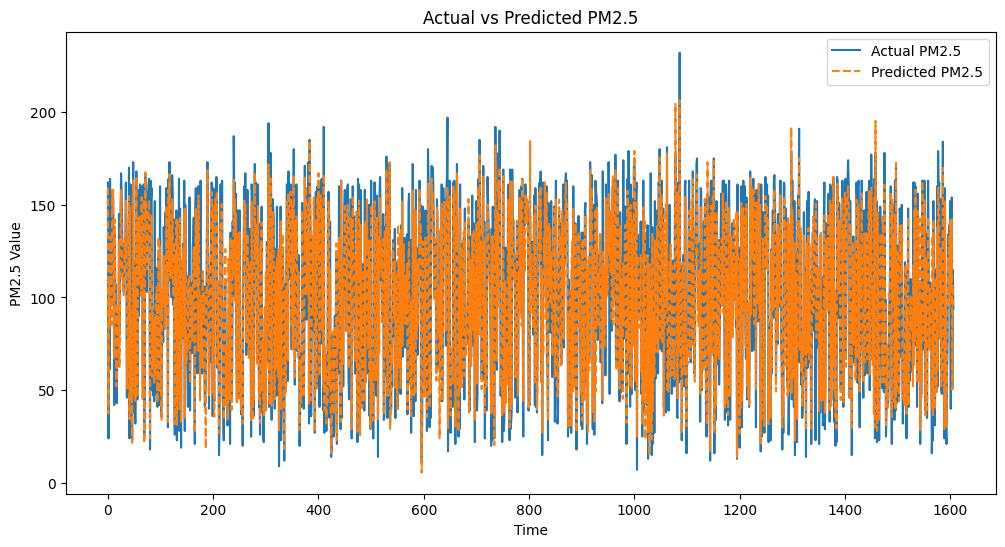

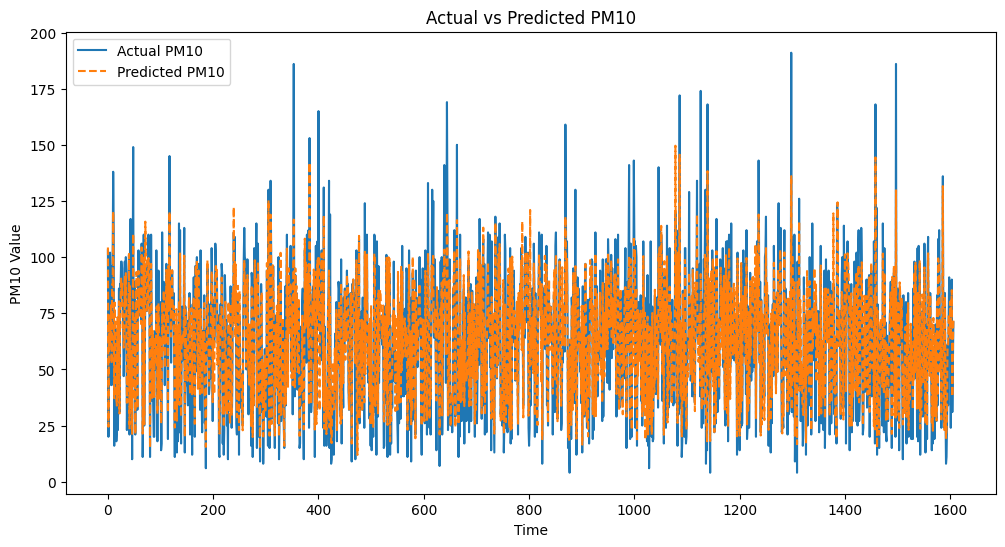

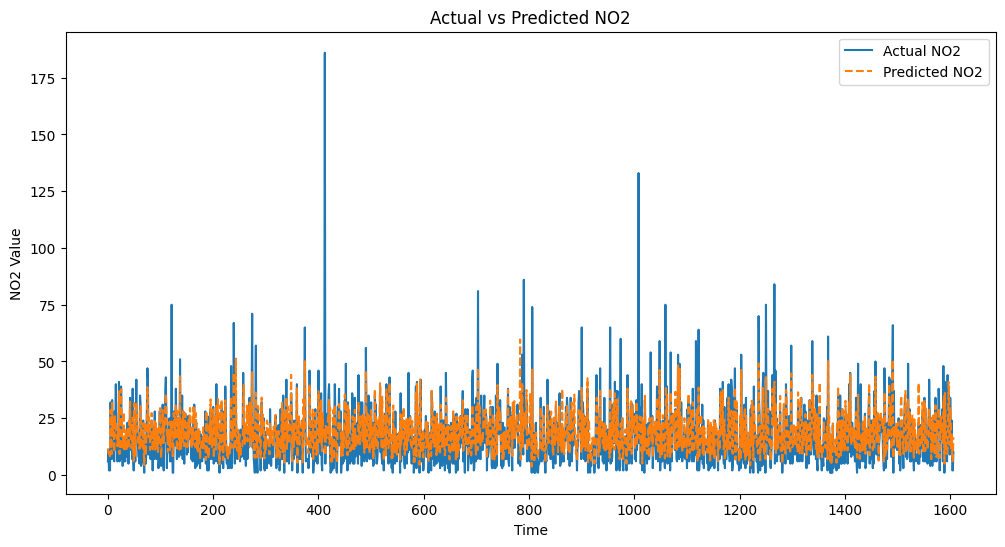

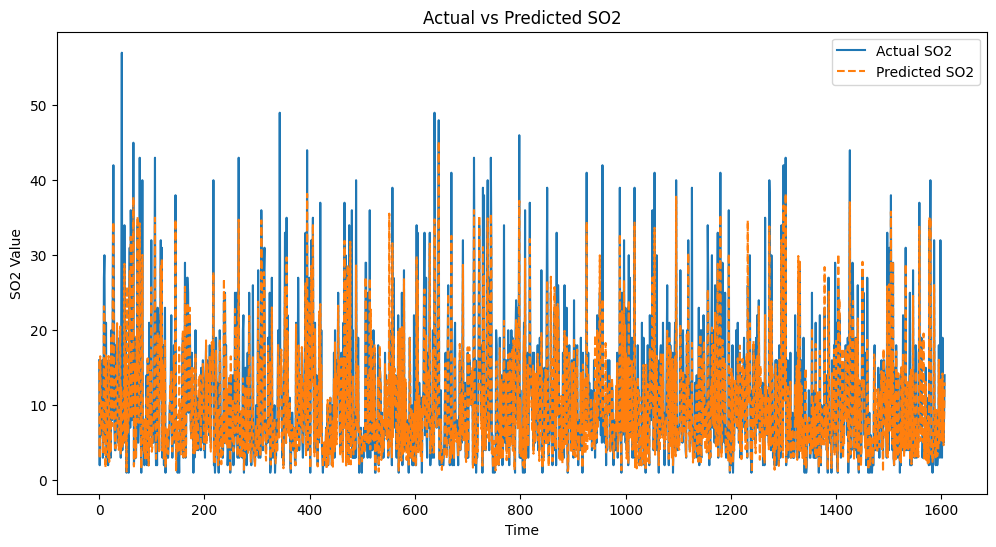

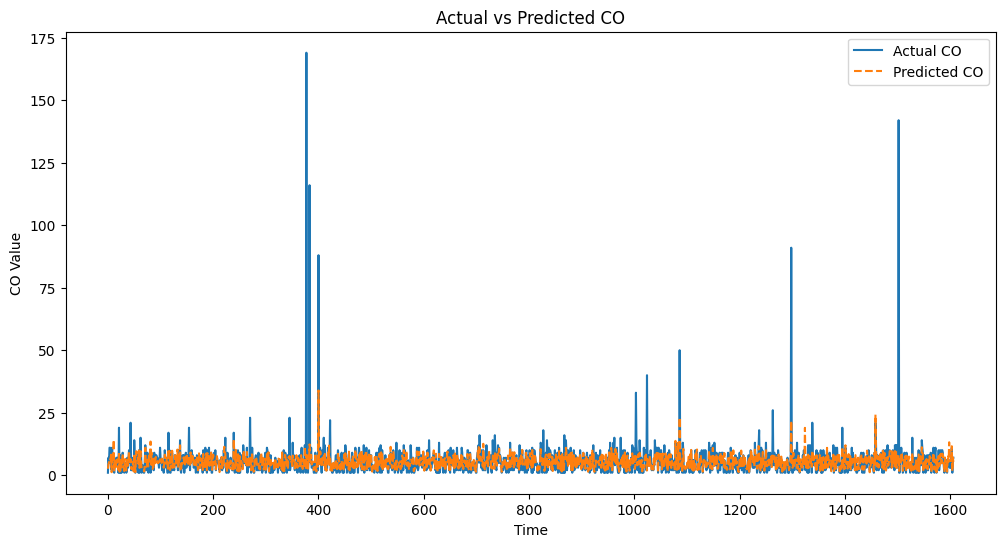

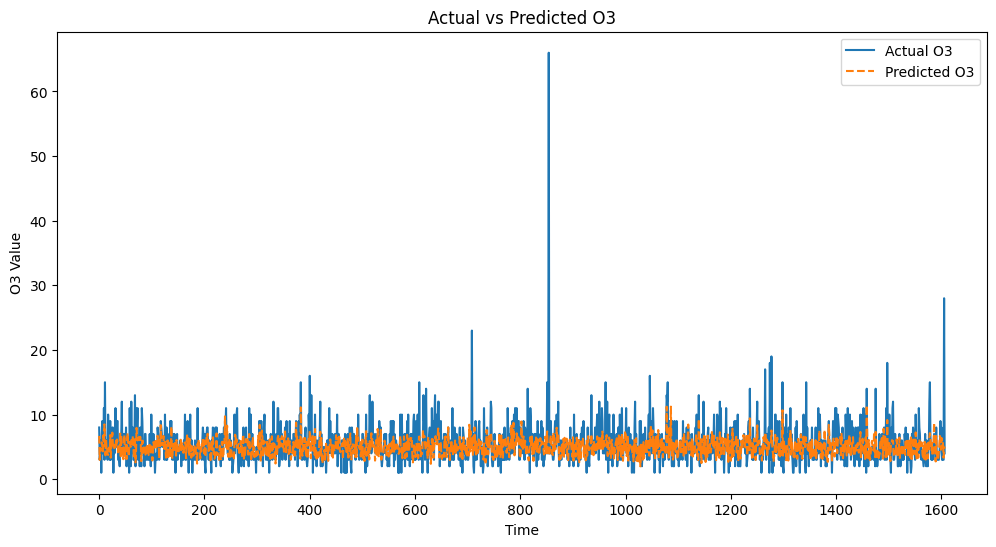

In [10]:
# Visualize each parameter separately
parameters = ["PM2.5", "PM10", "NO2", "SO2", "CO", "O3"]
for i in range(6):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual[:, i], label=f'Actual {parameters[i]}')
    plt.plot(y_pred_actual[:, i], label=f'Predicted {parameters[i]}', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel(f'{parameters[i]} Value')
    plt.title(f'Actual vs Predicted {parameters[i]}')
    plt.legend()
    plt.show()

In [11]:
# Save predictions to JSON
import json
predictions_dict = {parameters[i]: float(y_pred_actual[-1][i]) for i in range(6)}

with open("predictions.json", "w") as f:
    json.dump(predictions_dict, f)

print("Predictions saved to predictions.json")

Predictions saved to predictions.json


In [12]:
# Save the trained model
model.save("air_quality_model.h5")

# Download the model in Google Colab
from google.colab import files
files.download("air_quality_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>